In [1]:
img_path = "./content/001.jpg"

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [3]:
# get img_numpy
img       = Image.open(img_path).convert('RGB')
img_numpy = np.array(img) # (960, 720, 3)

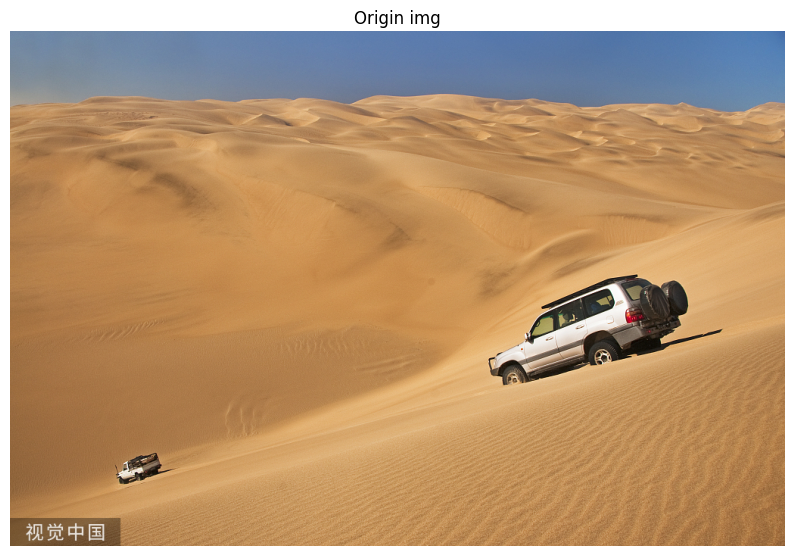

In [4]:
def show_img(img_num, img_np, img_name, title="", plt_size=(10, 8)):
    img_row = 1
    img_col = img_num
    if img_num % 2 == 0:
        img_row = 2
        img_col = int(img_num / 2)
    flg, ax = plt.subplots(img_row, img_col, figsize=plt_size)
    flg.suptitle(title)
    if img_num == 1:
        ax.imshow(img_np, 'gray')
        ax.set_title(img_name)
        ax.axis('off')
    elif img_row == 2:
        for i in range(img_row):
            for j in range(img_col):
                ax[i][j].imshow(img_np[i * img_col + j], 'gray')
                ax[i][j].set_title(img_name[i * img_col + j])
                ax[i][j].axis('off')
    else:
        for i in range(img_col):
            ax[i].imshow(img_np[i], 'gray')
            ax[i].set_title(img_name[i])
            ax[i].axis('off')

show_img(1, img_numpy, "Origin img")

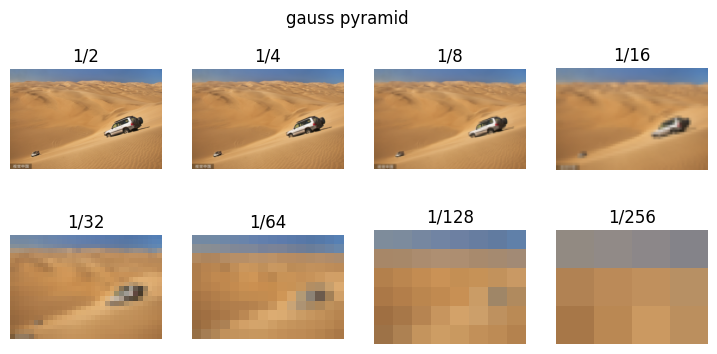

In [5]:
# gauss_pyramid
img_gauss = [img_numpy]
for _ in range(8):
    img_gauss.append(cv2.GaussianBlur(img_gauss[-1], (3, 3), 0)[0::2, :, :][:, 0::2, :])
    
show_img(8, img_gauss[1:], ["1/2", "1/4", "1/8", "1/16", "1/32", "1/64", "1/128", "1/256"], "gauss pyramid", (9, 4))

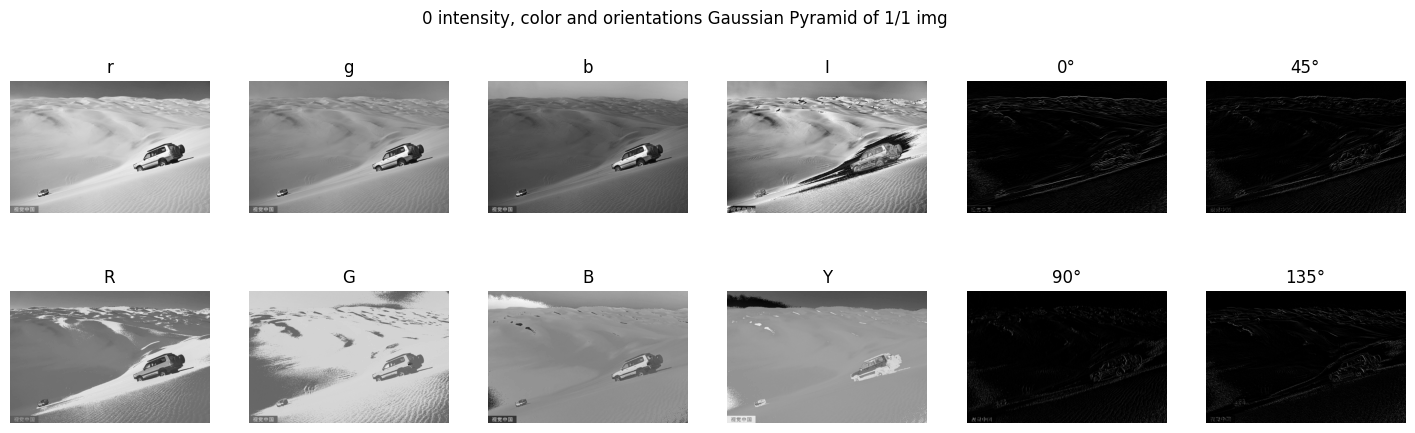

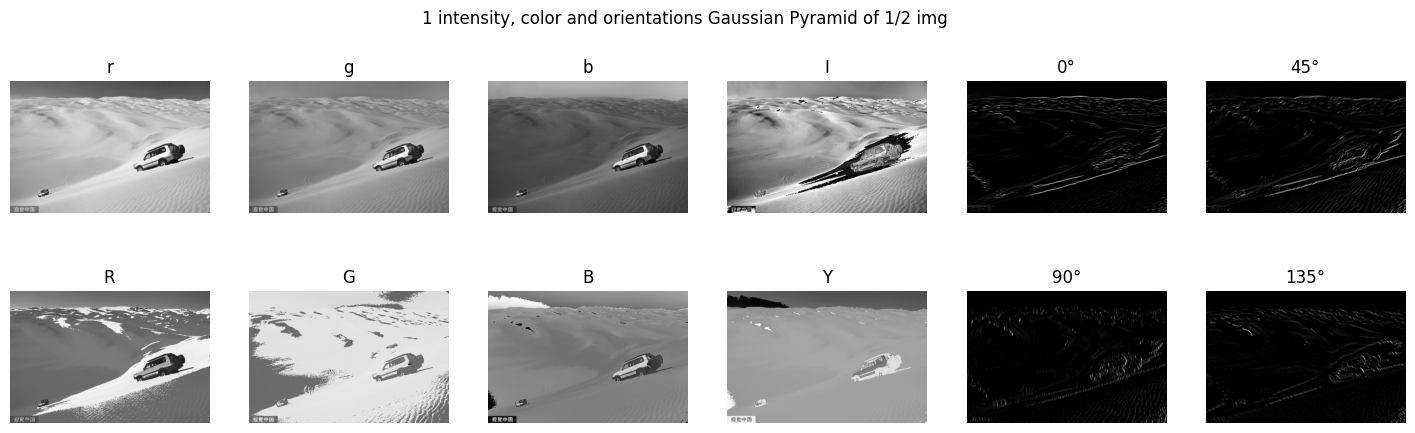

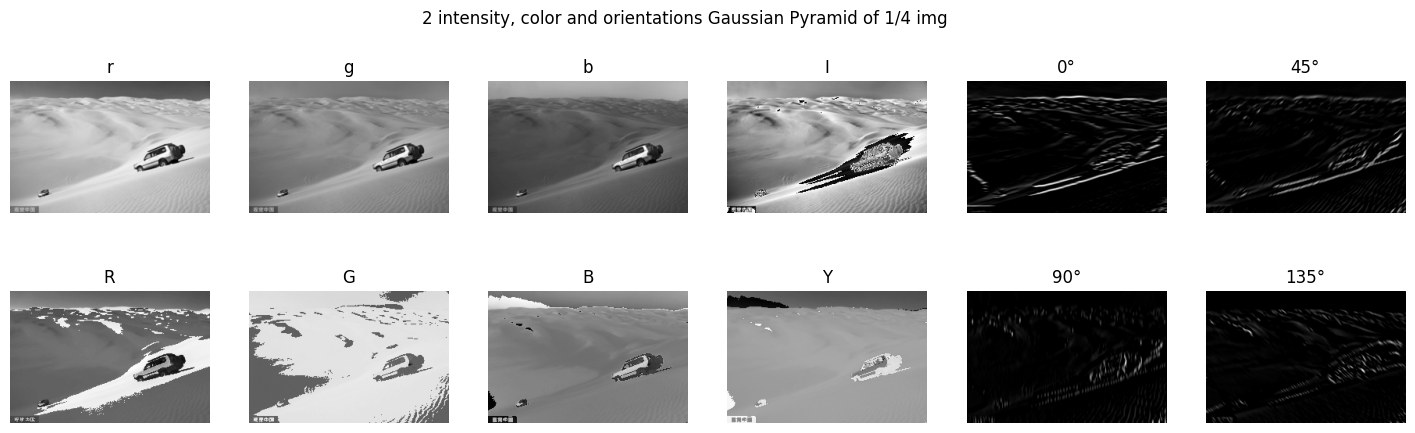

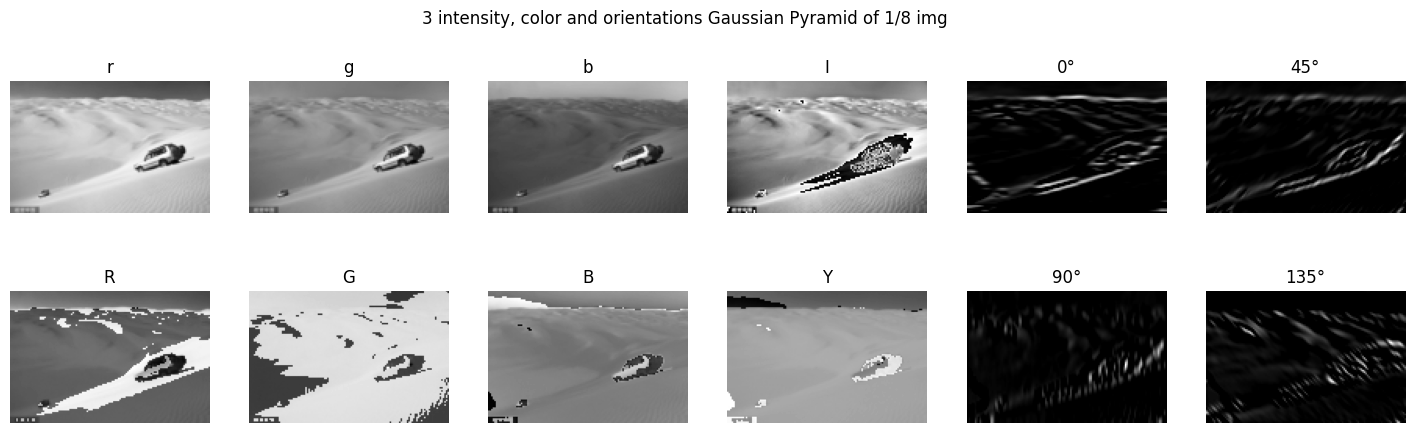

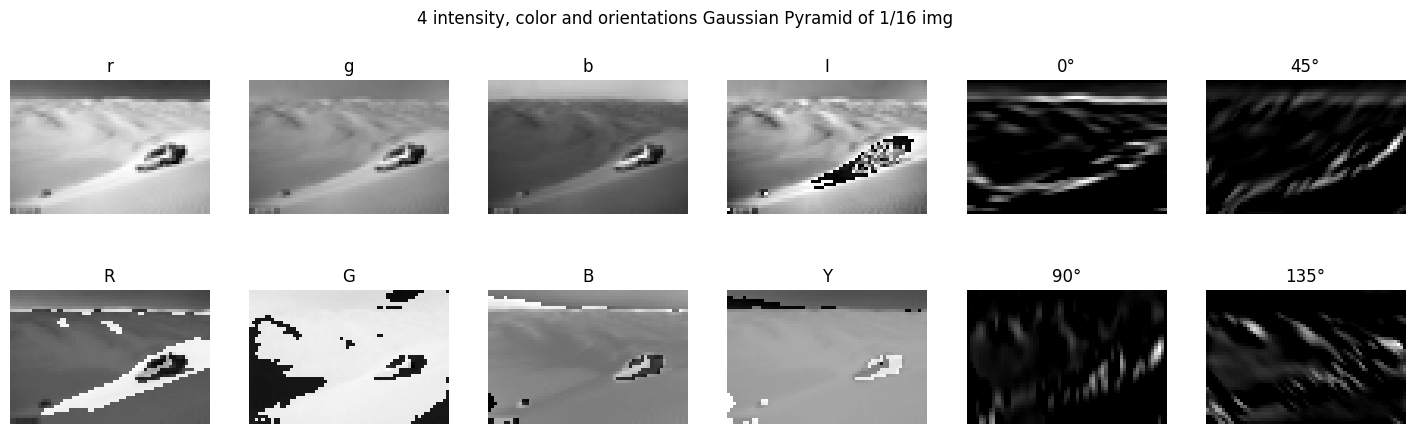

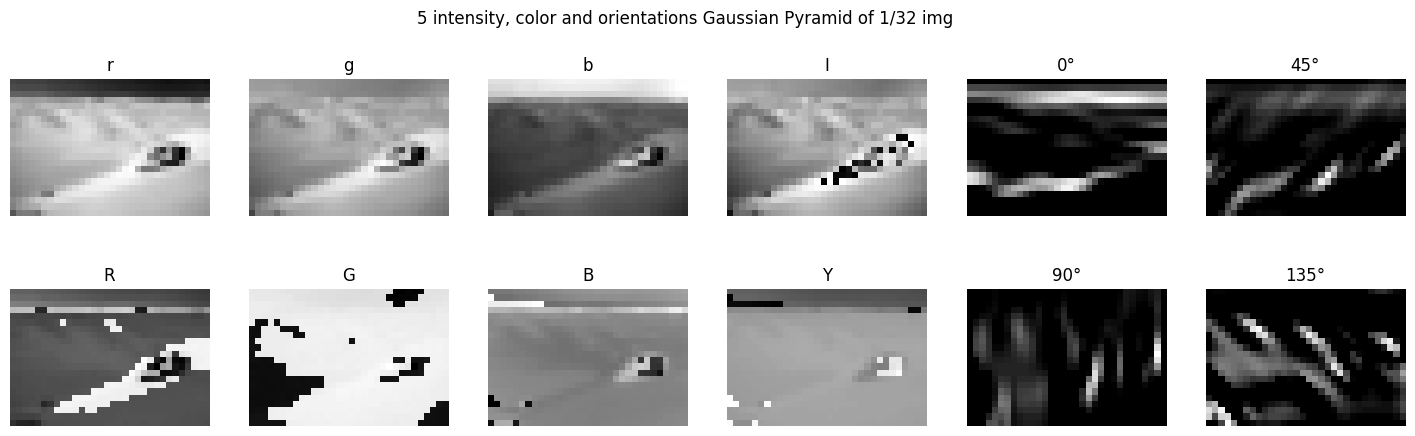

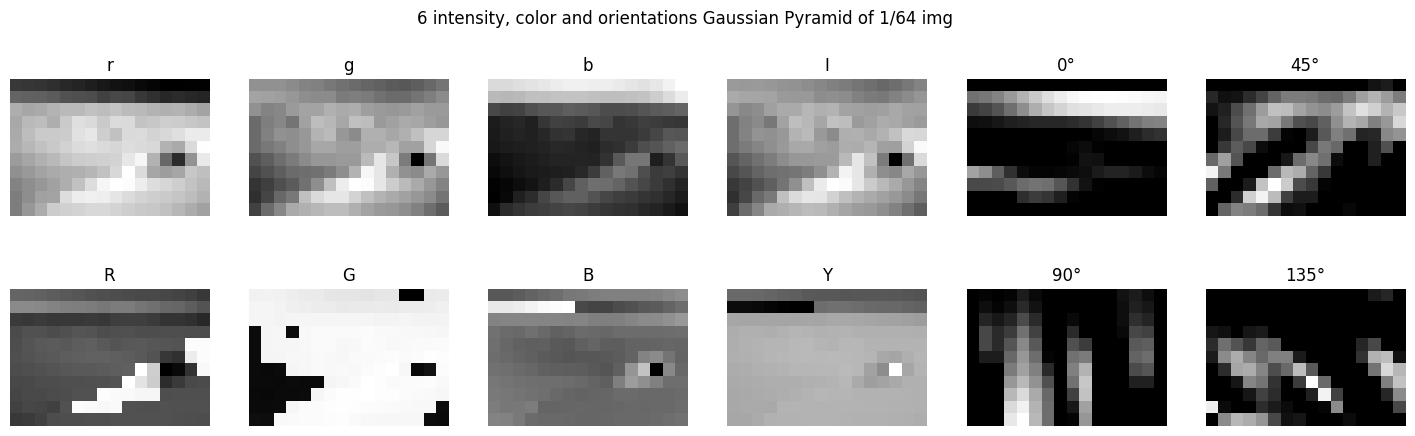

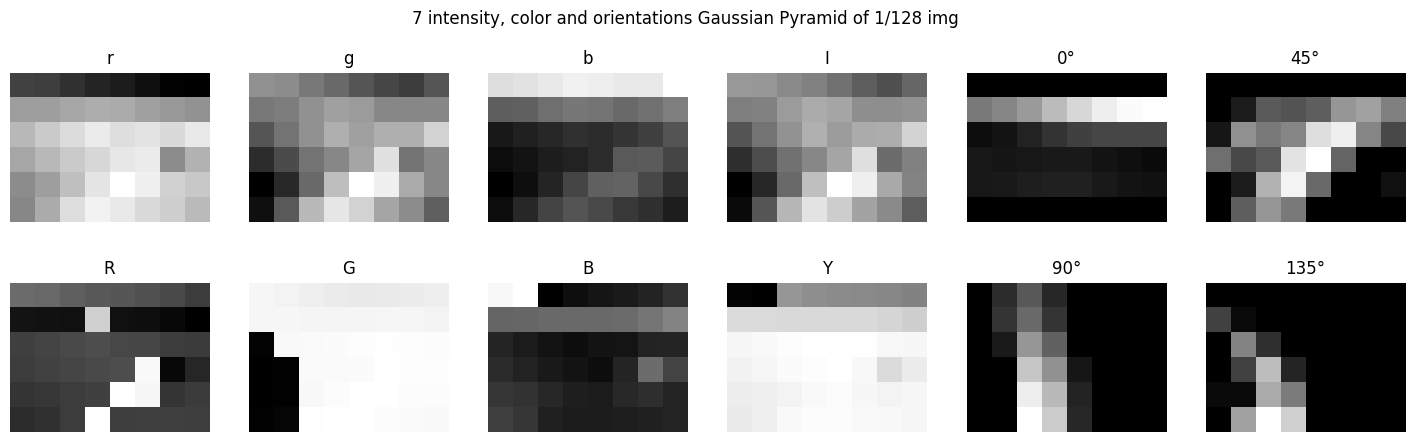

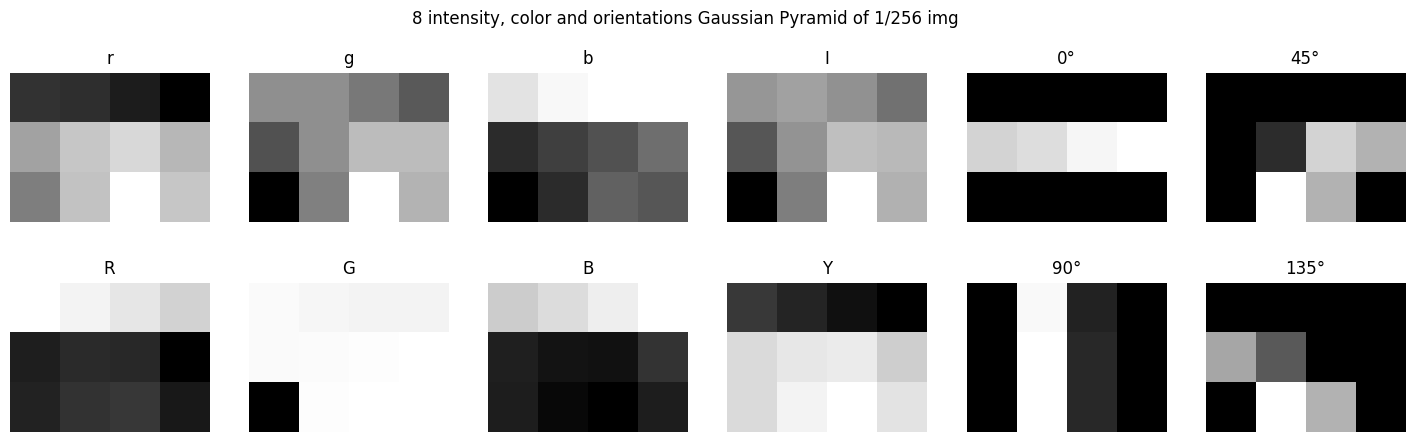

In [6]:
img_gauss_r = [_[:, : , 0] for _ in img_gauss]
img_gauss_g = [_[:, : , 1] for _ in img_gauss]
img_gauss_b = [_[:, : , 2] for _ in img_gauss]
img_gauss_gray = [i[:, :, 0] * 299 / 1000 + i[:, :, 1] * 587 / 1000 + i[:, :, 1] * 114 / 1000 for i in img_gauss]

# # intensity
img_gauss_I = [(img_gauss_r[i] + img_gauss_g[i] + img_gauss_b[i]) / 3 for i in range(len(img_gauss))]

# # color
img_gauss_R = [img_gauss_r[i] - (img_gauss_g[i] + img_gauss_b[i]) / 2 for i in range(len(img_gauss))]
img_gauss_G = [img_gauss_g[i] - (img_gauss_r[i] + img_gauss_b[i]) / 2 for i in range(len(img_gauss))]
img_gauss_B = [img_gauss_b[i] - (img_gauss_r[i] + img_gauss_g[i]) / 2 for i in range(len(img_gauss))]
img_gauss_Y = [(img_gauss_r[i] + img_gauss_g[i]) / 2 - np.abs(img_gauss_r[i] - img_gauss_g[i]) / 2 - img_gauss_b[i] for i in range(len(img_gauss))]


# # orientations
def gabor_kernel(ksize, sigma, gamma, lamda, alpha, psi):
    '''
    reference
    https://en.wikipedia.org/wiki/Gabor_filter
    '''
 
    sigma_x = sigma
    sigma_y = sigma / gamma
 
    ymax = xmax = ksize // 2
    xmin, ymin = -xmax, -ymax
    (y, x) = np.meshgrid(np.arange(ymin, ymax + 1), np.arange(xmin, xmax + 1))
 
    x_alpha = y * np.sin(alpha) + x * np.cos(alpha)
    y_alpha = y * np.cos(alpha) - x * np.sin(alpha)
    exponent = np.exp(-0.5 * (x_alpha ** 2 / sigma_x ** 2 + y_alpha ** 2 / sigma_y ** 2))
    kernel = exponent * np.cos(2 * np.pi / lamda * x_alpha + psi)
    return kernel


def gabor_filter(gray_img, ksize, sigma, gamma, lamda, psi):
    filters = []
    for alpha in np.arange(0, np.pi, np.pi / 4):
        kern = gabor_kernel(ksize=ksize, sigma=sigma, gamma=gamma,
                            lamda=lamda, alpha=alpha, psi=psi)
        filters.append(kern)
    return_img = []
    i = 0
    for kern in filters:
        fimg = cv2.filter2D(gray_img, ddepth=cv2.CV_8U, kernel=kern)
        return_img.append(fimg)
    return np.array(return_img)

img_gauss_O = [np.array(gabor_filter(img_gauss_gray[i], 9, 1, 0.5, 5, -np.pi/2)) for i in range(len(img_gauss))]

for i in range(len(img_gauss)):
    show_img(12, 
             [img_gauss_r[i], img_gauss_g[i], img_gauss_b[i], img_gauss_I[i], img_gauss_O[i][0], img_gauss_O[i][1],
              img_gauss_R[i], img_gauss_G[i], img_gauss_B[i], img_gauss_Y[i], img_gauss_O[i][2], img_gauss_O[i][3]], 
             ["r", "g", "b", "I", "0°",  "45°",
              "R", "G", "B", "Y", "90°", "135°"],
             f"{i} intensity, color and orientations Gaussian Pyramid of 1/{2**i} img", 
             (18, 5))

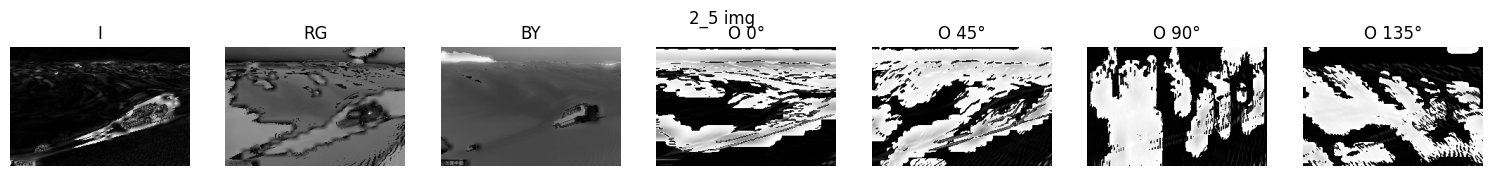

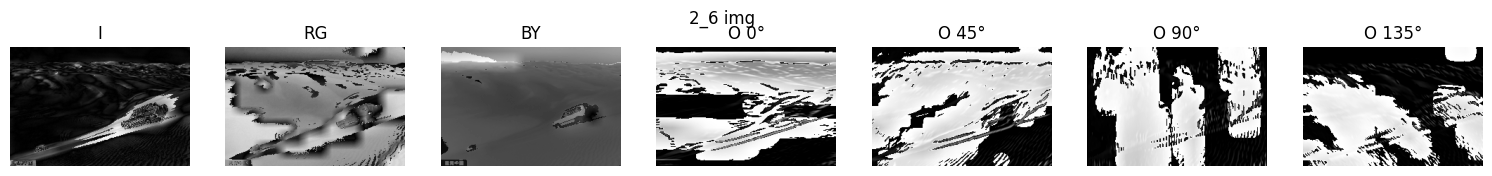

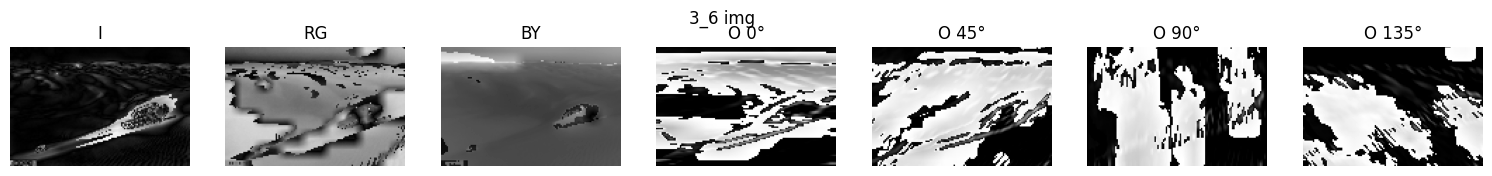

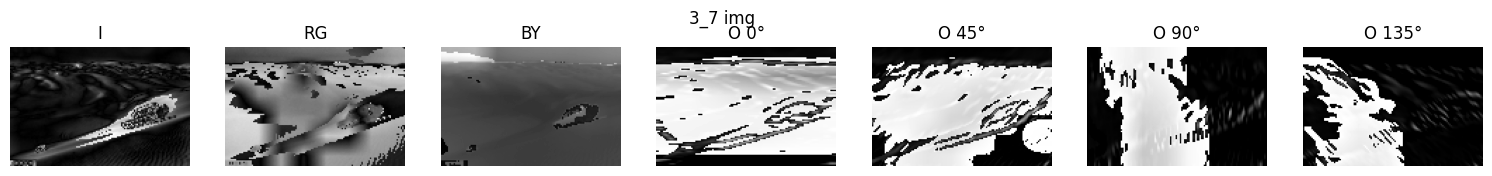

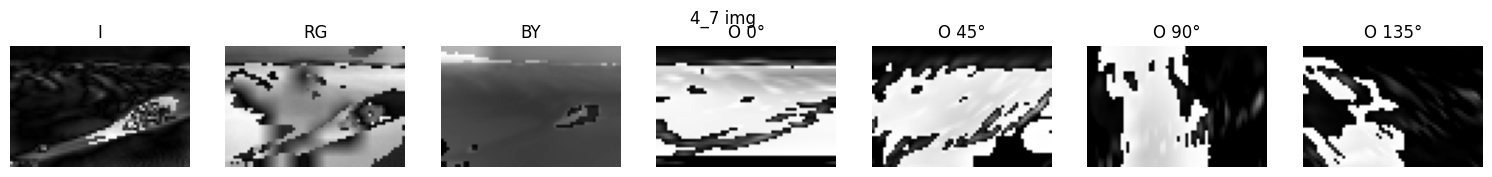

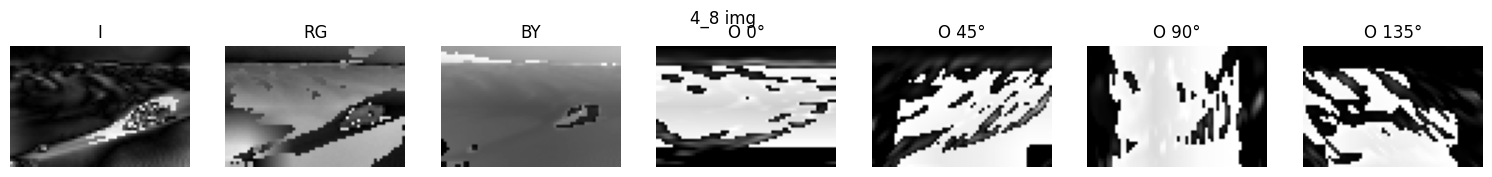

In [7]:
# Feature map
all_key = []
I_diff  = {}
O_diff  = {}
RG_diff = {}
BY_diff = {}
for i in range(2, 5):
    for j in range(i + 3, i + 5):
        if j >= len(img_gauss):
            continue
        key = f"{i}_{j}"
        all_key.append(key)
        I_diff[key]  = np.abs(img_gauss_I[i]                  - cv2.resize(img_gauss_I[j],                  img_gauss_I[i].shape[-1::-1]))
        O_diff[key]  = np.abs(img_gauss_O[i]                  - np.array([cv2.resize(img_gauss_O[j][k], img_gauss_O[i][k].shape[-1::-1]) for k in range(img_gauss_O[i].shape[0])]))
        RG_diff[key] = np.abs(img_gauss_R[i] - img_gauss_G[i] - cv2.resize(img_gauss_G[j] - img_gauss_R[j], img_gauss_R[i].shape[-1::-1]))
        BY_diff[key] = np.abs(img_gauss_B[i] - img_gauss_Y[i] - cv2.resize(img_gauss_Y[j] - img_gauss_B[j], img_gauss_B[i].shape[-1::-1]))

# 
for key in all_key:
    show_img(7, 
             [I_diff[key], RG_diff[key], BY_diff[key], O_diff[key][0], O_diff[key][1], O_diff[key][2], O_diff[key][3]],
             ["I", "RG", "BY", "O 0°", "O 45°", "O 90°", "O 135°"],
             f"{key} img", (19, 2))

In [8]:
# Conspicuity map
def normalize(img_np):
    img_np = img_np * 1.0
    img_np /= (np.sum(img_np) + 0.01)
    
    step = 16
    m = []
    
    for i in range(0, img_np.shape[0] - step):
        for j in range(0, img_np.shape[1] - step):
            m.append(np.min(img_np[i:i + step, j:j + step]))
    
    m = np.sum(np.array(m)) / len(m)
    
    img_np = img_np + ((1 - m) ** 2)
    return img_np

for key in all_key:
    I_diff[key] = normalize(I_diff[key])
    O_diff[key] = np.array([normalize(O_diff[key][i]) for i in range(O_diff[key].shape[0])])
    RG_diff[key] = normalize(RG_diff[key])
    BY_diff[key] = normalize(BY_diff[key])

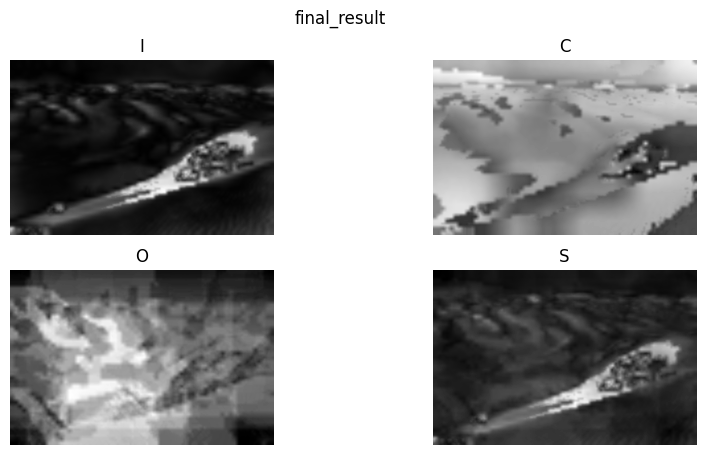

In [9]:
I_sum = {}
C_sum = {}
O_sum = {}
for key in all_key:
    fir, sec = [int(_) for _ in key.split('_')]
    if fir not in I_sum:
        I_sum[fir] = I_diff[key]
        C_sum[fir] = RG_diff[key] + BY_diff[key]
        O_sum[fir] = np.sum(O_diff[key], axis=0)
    else:
        I_sum[fir] += I_diff[key]
        C_sum[fir] += RG_diff[key] + BY_diff[key]
        O_sum[fir] += np.sum(O_diff[key], axis=0)

I = np.sum(np.array([cv2.resize(I_sum[key], img_gauss_I[0].shape[-1::-1]) for key in I_sum.keys()]), axis=0)
I = normalize(I)
C = np.sum(np.array([cv2.resize(C_sum[key], img_gauss_R[0].shape[-1::-1]) for key in C_sum.keys()]), axis=0)
C = normalize(C)
O = np.sum(np.array([cv2.resize(O_sum[key], img_gauss_O[0][0].shape[-1::-1]) for key in O_sum.keys()]), axis=0)
O = normalize(O)

# Linear combinations
S = (I + O + C) / 3
S = np.floor((S - np.min(S)) * 255 / (np.max(S) - np.min(S)));
S = np.floor(255 * S / np.max(S));
show_img(4, [I, C, O, S], ["I", "C", "O", "S"], "final_result", (10, 5))